In [88]:
import geopandas
import rioxarray
import pathlib
import matplotlib
import numpy
import shapely
import scipy.spatial
import xarray

Load in files - note using REC2.4 only because Ude used this when deriving population and slope over catchment patches. In future we should be using REC2.5

In [44]:
base_path = pathlib.Path(r"C:\Users\pearsonra\Documents\data\river_bathemetry")
rec2 = geopandas.read_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\rec_domains\rec2_rivers.shp")
#dn3 = geopandas.read_file(r"")
domains = geopandas.read_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\rec_domains\super_domains_sort_traces.gpkg")
waikanae_lower_catchment = geopandas.read_file(
    r"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\small_waikanae.shp")
westport_catchment = geopandas.read_file(
    r"C:\Users\pearsonra\Documents\data\Westport\catchments\Rough_Catchment_outline\Rough_Catchment_outline.zip")

Specify relevant fids

In [3]:
domain_waikanae_fid = 65 # minus one from that specified in QGIS
domain_westport_fid = 102 # minus one from that specified in QGIS
rec2_waikanae_id = 9253579
rec2_westport_id = 12035600

In [4]:
domains.iloc[domain_westport_fid]['geometry']

Cycle through the nodes from the initial ID using the NextDownID that matches the earch above and putting into a list. This can become a new GeoPandasDataframe of all polylines in a from coast to the upper catchment.

## A function to extract all polylines associated with a river

In [6]:
rec2.columns

Index(['HydroID', 'NextDownID', 'CATAREA', 'CUM_AREA', 'nzsegment', 'Enabled',
       'LENGTHDOWN', 'Headwater', 'Hydseq', 'StreamOrde', 'euclid_dis',
       'upElev', 'downElev', 'upcoordX', 'downcoordX', 'downcoordY',
       'upcoordY', 'sinuosity', 'nzreach_re', 'headw_dist', 'segslpmax',
       'segslpmean', 'LID', 'reachtype', 'FROM_NODE', 'TO_NODE', 'Shape_Leng',
       'geometry'],
      dtype='object')

In [7]:
10_000*10_000

100000000

In [9]:
rec2[rec2['nzsegment']==rec2_waikanae_id]['CUM_AREA']

253495    152753696.0
Name: CUM_AREA, dtype: float64

In [10]:
def get_down_stream_reaches(rec: geopandas.GeoDataFrame, reach_id: int, reaches: geopandas.GeoDataFrame, i: int):
    if i>8000:
        print(f"Reached recursion limit at: {i}")
        return reaches, i
    i += 1
    down_stream_reaches = rec[rec['NextDownID']==reach_id]
    reaches = reaches.append(down_stream_reaches)
    for index, down_stream_reach in down_stream_reaches.iterrows():
        if not down_stream_reach['Headwater']: 
            reaches, i = get_down_stream_reaches(rec=rec, reach_id=down_stream_reach['nzsegment'], reaches=reaches, i=i)
    
    return reaches, i

## Generate shape files for the Waikanae river

<AxesSubplot:>

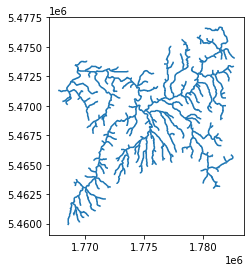

In [34]:
area_threshold = 10_000_000 # 10_000_000. 100_000_000
waikanae_river = rec2[rec2['nzsegment']==rec2_waikanae_id]
waikanae_river, i = get_down_stream_reaches(rec2, rec2_waikanae_id, waikanae_river, i=0)
waikanae_river.plot()

### Extract flat region

In [35]:
flat_waikanae_river = waikanae_river.clip(domains.iloc[domain_waikanae_fid]['geometry'], keep_geom_type=True)

In [36]:
flat_waikanae_river_polygon = geopandas.GeoDataFrame(geometry=flat_waikanae_river.buffer(150))
flat_waikanae_river_polygon['label'] = 1
flat_waikanae_river_polygon = flat_waikanae_river_polygon.dissolve(by='label')

<AxesSubplot:>

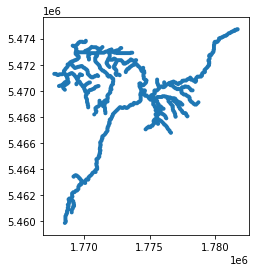

In [37]:
flat_waikanae_river_polygon.plot()

### Extract flat region above area threshold
Extract teh flat reaches with more upstream area than the set threshold

<AxesSubplot:>

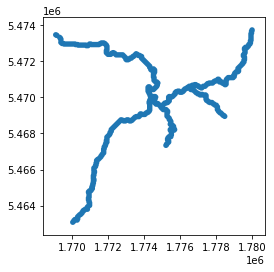

In [38]:
flat_waikanae_river_area = flat_waikanae_river[flat_waikanae_river['CUM_AREA']>area_threshold]
flat_waikanae_river_area_polygon = geopandas.GeoDataFrame(geometry=flat_waikanae_river_area.buffer(150))
flat_waikanae_river_area_polygon['label'] = 1
flat_waikanae_river_area_polygon = flat_waikanae_river_area_polygon.dissolve(by='label')
flat_waikanae_river_area_polygon.plot()

### Save out Waikanae river shapefiles

In [39]:
#waikanae_river.to_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\waikanae_polyline.geojson")
#flat_waikanae_river.to_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\waikanae_flat_polyline.geojson")
#flat_waikanae_river_polygon.to_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\waikanae_flat_polygon.geojson")
flat_waikanae_river_area_polygon.to_file(fr"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\waikanae_polygon_{area_threshold}.geojson")

## Generate shape files for the Westport river

In [49]:
area_threshold = 10_000_000 # 10_000_000. 100_000_000
westport_river = rec2[rec2['nzsegment']==rec2_westport_id]
westport_river, i = get_down_stream_reaches(rec2, rec2_westport_id, westport_river, i=0)
#westport_river.plot()

In [50]:
flat_westport_river = westport_river.clip(domains.iloc[domain_westport_fid]['geometry'], keep_geom_type=True)
#flat_westport_river.plot()

### Create flat polygon

In [163]:
flat_westport_river_polygon = geopandas.GeoDataFrame(geometry=flat_westport_river.buffer(300))
flat_westport_river_polygon['label'] = 1
flat_westport_river_polygon = flat_westport_river_polygon.dissolve(by='label')
# flat_westport_river_polygon.plot()

### Extract flat region above area threshold
Extract the flat reaches with more upstream area than the set threshold

<AxesSubplot:>

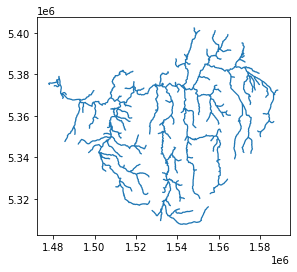

In [51]:
flat_westport_river_area = flat_westport_river[flat_westport_river['CUM_AREA']>area_threshold]
flat_westport_river_area_polygon = geopandas.GeoDataFrame(geometry=flat_westport_river_area.buffer(300))
flat_westport_river_area_polygon['label'] = 1
flat_westport_river_area_polygon = flat_westport_river_area_polygon.dissolve(by='label')
flat_westport_river_area_polygon.plot()

<AxesSubplot:>

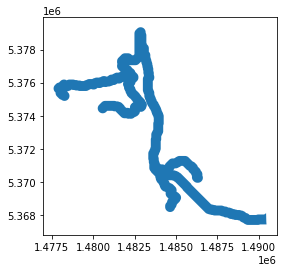

In [52]:
flat_westport_river_area_polygon_in_catchment = flat_westport_river_area_polygon.clip(westport_catchment, keep_geom_type=True)
flat_westport_river_area_polygon_in_catchment.plot()

### Save out Westport river files

In [53]:
#westport_river.to_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\westport_polyline.geojson")
#flat_westport_river.to_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\westport_flat_polyline.geojson")
#flat_westport_river_polygon.to_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\westport\westport_flat_polygon.geojson")
flat_westport_river_area_polygon_in_catchment.to_file(fr"C:\Users\pearsonra\Documents\data\river_bathemetry\westport\westport_polygon_{area_threshold}.geojson")

# Separate out River - edge detection - after manual placement of river in QGIS based of DEM & satallite
At polyline nodes - calculate perpindicular transect - look at slope change along this - cell to cell & slope change
* calculate width
* calculate avg elevation of 'river' bit

In [135]:
transect_length = 100 # in both directions
resolution = 1

## Waikanae

In [136]:
waikanae_manual_rivers = geopandas.read_file(base_path / "waikanae\manual_river_centre_100000000\manual_river_centre_100000000.geojson")
with rioxarray.rioxarray.open_rasterio(base_path / r"waikanae\clipped\results\1m_100000000_gnd.nc", masked=True) as waikane_dem:
            waikane_dem.load()
with rioxarray.rioxarray.open_rasterio(base_path / r"waikanae\clipped\results\1m_100000000_gnd_linear.nc", masked=True) as waikane_dem_linear:
            waikane_dem_linear.load()

### Get perpindicular sample lines from manual rivers
#### Focus on main channel

### Sample elevations along main channel

In [138]:
def transects_along_reaches(channel_centre_lines: geopandas.GeoDataFrame, channel_id: int, transect_length: float):
    transects = {'geometry':[], 'nx':[], 'ny':[], 'midpoint': []}
    (x_array, y_array) = waikanae_manual_rivers.loc[channel_id].geometry.xy
    for i in range(len(x_array)-1):
        # calculate midpoint
        midpoint = [(x_array[i] + x_array[i+1])/2, (y_array[i] + y_array[i+1])/2]
        normal = 0#(x_array[i] - x_array[i+1]) / (y_array[i+1] - y_array[i])
        dx = (x_array[i+1] - x_array[i])/numpy.sqrt((x_array[i+1] - x_array[i])**2 + (y_array[i+1] - y_array[i])**2)
        dy = (y_array[i+1] - y_array[i])/numpy.sqrt((x_array[i+1] - x_array[i])**2 + (y_array[i+1] - y_array[i])**2)
        #print(f"midpoint={midpoint}, normal={normal}, dx={dx}, dy={dy}")
        transects['geometry'].append(shapely.geometry.LineString([[midpoint[0] + transect_length * dy, midpoint[1] - transect_length * dx],
                                                      midpoint,
                                                      [midpoint[0] - transect_length * dy, midpoint[1] + transect_length * dx]]))
        transects['nx'].append(-dy)
        transects['ny'].append(-dx)
        transects['midpoint'].append(shapely.geometry.Point(midpoint))
    transects = geopandas.GeoDataFrame(transects) 
    return transects

In [139]:
transects = transects_along_reaches(waikanae_manual_rivers, 0)

<AxesSubplot:>

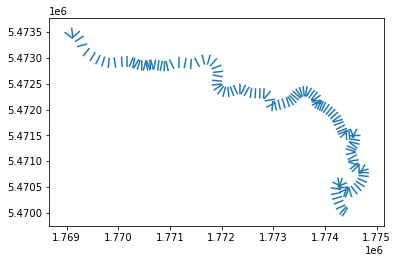

In [140]:
transects.plot()

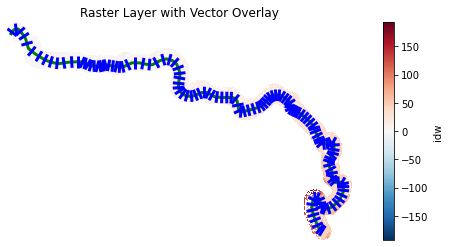

In [141]:
f, ax = matplotlib.pyplot.subplots(figsize=(11, 4))

waikane_dem.plot(ax=ax)

waikanae_manual_rivers[waikanae_manual_rivers['id']==0].plot(color='green', linewidth=3, ax=ax)

transects.plot(color='blue',
                    edgecolor='teal',
                    linewidth=3,
                    ax=ax)

ax.set(title="Raster Layer with Vector Overlay")
ax.axis('off')
matplotlib.pyplot.show()

### Sample elevations along each transect at the resolution

In [156]:
def sample_from_transects(transects: geopandas.GeoDataFrame, dem: xarray.core.dataarray.DataArray, transect_length: float):
    
    transect_samples = {'elevations': [], 'xx': [], 'yy': [], 'min_z':[]}
    
    # create tree to sample from
    grid_x, grid_y = numpy.meshgrid(dem.x, dem.y)
    xy_in = numpy.concatenate([[grid_x.flatten()], [grid_y.flatten()]], axis=0).transpose()
    tree = scipy.spatial.KDTree(xy_in)
    
    # cycle through each transect - calculate sample points then look up
    for index, row in transects.iterrows():
        #calculate xx, and yy points to sample at
        if row['nx'] == 0:
            xx=row.midpoint.x+numpy.zeros(int(transect_length/resolution))
        else:
            xx=row.midpoint.x+numpy.arange(-row['nx']*transect_length, 
                                           row['nx']*transect_length, 
                                           resolution*row['nx'])
        if row['ny'] == 0:
            yy=row.midpoint.y+numpy.zeros(int(transect_length/resolution))
        else:
            yy=row.midpoint.y+numpy.arange(-row['ny']*transect_length,
                                           row['ny']*transect_length,
                                           resolution*row['ny'])
        
        # Sample the elevations at along the transect
        distances, indices = tree.query(numpy.concatenate([[xx[:min(len(xx), len(yy))-1]],
                                                           [yy[:min(len(xx), len(yy))-1]]], axis=0).transpose())
        elevations = dem.data.flatten()[indices]
        transect_samples['elevations'].append(elevations)
        transect_samples['min_z'].append(numpy.nanmin(elevations))
    
    return transect_samples

In [157]:
transect_samples = sample_from_transects(transects, waikane_dem, transect_length)
transect_samples_linear = sample_from_transects(transects, waikane_dem_linear, transect_length)

C:\Users\PEARSO~1\AppData\Local\Temp/ipykernel_7572/78368583.py:31: RuntimeWarning: All-NaN slice encountered
  transect_samples['min_z'].append(numpy.nanmin(elevations))


### Plot transect elevations

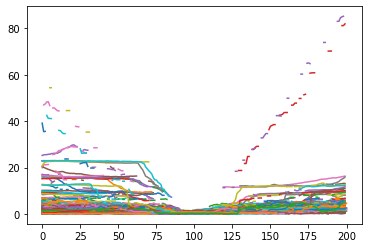

In [151]:
for elevations, min_z in zip(transect_samples['elevations'], transect_samples['min_z']):
    matplotlib.pyplot.plot(elevations - min_z)

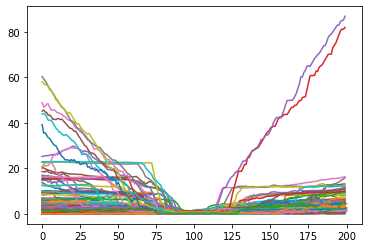

In [152]:
for elevations, min_z in zip(transect_samples_linear['elevations'], transect_samples_linear['min_z']):
    matplotlib.pyplot.plot(elevations - min_z)

# Calculate width and slope
Use the linear interpolation as we have results everywhere

In [124]:
transects['min_z'] = transect_samples_linear['min_z']

In [125]:
transects

geometry        nx        ny  \
0    LINESTRING (1769117.198 5473380.392, 1769037.4... -0.797406 -0.603443   
1    LINESTRING (1769121.402 5473392.228, 1769107.7... -0.136637 -0.990621   
2    LINESTRING (1769104.137 5473389.521, 1769179.2...  0.751165 -0.660115   
3    LINESTRING (1769159.800 5473316.770, 1769243.3...  0.835705 -0.549178   
4    LINESTRING (1769198.950 5473218.638, 1769295.1...  0.962064 -0.272824   
..                                                 ...       ...       ...   
128  LINESTRING (1774139.583 5470262.884, 1774235.5...  0.959288 -0.282430   
129  LINESTRING (1774172.675 5470168.626, 1774265.3...  0.926947 -0.375193   
130  LINESTRING (1774214.073 5470072.744, 1774305.0...  0.909688 -0.415292   
131  LINESTRING (1774285.225 5469970.621, 1774349.7...  0.644999 -0.764183   
132  LINESTRING (1774335.252 5469933.308, 1774387.7...  0.524748 -0.851258   

                                        midpoint      min_z  
0    POINT (1769037.456959542 5473440.736389701)   0.314488  
1    POINT (1769107.738691209 5473491.289915987)   0.458205  
2    POINT (1769179.253435711 5473455.532543736)   0.204691  
3    POINT (1769243.370103197 5473371.687670872)   0.111065  
4    POINT (1769295.156642319 5473245.920361573)  -0.017787  
..                                           ...        ...  
128  POINT (1774235.511580557 5470291.126539668)  40.210000  
129  POINT (1774265.369966024 5470206.144981034)  40.841562  
130  POINT (1774305.041946713 5470114.273025753)  41.257511  
131   POINT (1774349.725124964 5470047.03945848)  41.356534  
132  POINT (1774387.726706466 5470018.433872404)  41.848859  

[133 rows x 5 columns]

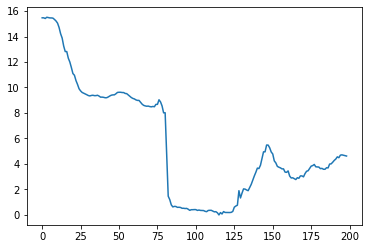

In [169]:
i=100
matplotlib.pyplot.plot(transect_samples_linear['elevations'][i]-transect_samples_linear['min_z'][i])
elevation = transect_samples_linear['elevations'][i]-transect_samples_linear['min_z'][i]

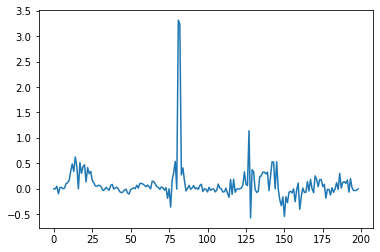

In [192]:
matplotlib.pyplot.plot(slope)

In [191]:
assert numpy.floor(len(elevation)/2) != len(elevation)/2, "Expect an odd length"
slope=numpy.empty_like(elevation)
centre_index = int(numpy.floor(len(elevation)/2))
for i in numpy.arange(0, centre_index, 1):
    # work forward calculating the slope
    slope[centre_index+i] = elevation[centre_index + (i + 1)] - elevation[centre_index + i]
    # work backward calculating the slope
    slope[centre_index-i] = elevation[centre_index - (i + 1)] - elevation[centre_index - i]

### Save out transects

In [394]:
transects.drop(columns=['midpoint']).to_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\waikanae_trasects_of_manual.geojson")

In [398]:
transects.drop(columns=['midpoint'])

geometry        nx        ny
0   LINESTRING (1769117.198 5473380.392, 1769037.4... -0.797406 -0.603443
1   LINESTRING (1769121.402 5473392.228, 1769107.7... -0.136637 -0.990621
2   LINESTRING (1769104.137 5473389.521, 1769179.2...  0.751165 -0.660115
3   LINESTRING (1769159.800 5473316.770, 1769243.3...  0.835705 -0.549178
4   LINESTRING (1769198.950 5473218.638, 1769295.1...  0.962064 -0.272824
..                                                ...       ...       ...
56  LINESTRING (1772865.955 5472046.711, 1772955.6...  0.897089 -0.441850
57  LINESTRING (1772975.536 5471969.273, 1772982.7...  0.072536 -0.997366
58  LINESTRING (1773064.553 5471980.978, 1773040.1... -0.244277 -0.969706
59  LINESTRING (1773138.578 5471999.182, 1773115.3... -0.232396 -0.972621
60  LINESTRING (1773235.529 5472025.910, 1773206.8... -0.286392 -0.958112

[61 rows x 3 columns]